# Discrete Population Compartmental Model

Treats the population as discrete rather than continuous.

In [66]:
# Import those libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time
from operator import add
from scipy.stats import binom
from numpy import random
from joblib import Parallel, delayed
import collections
import csv

In [67]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [68]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]

# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring rural sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Pinjarra') & (waloc['City / Town'] != 'Drummond Cove') &
                  (waloc['City / Town'] != 'Bridgetown') & (waloc['City / Town'] != 'Binningup') &
                 (waloc['City / Town'] != 'Dampier') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

In [69]:
# Create a network from a weekly dataset
my_data = genfromtxt('/Volumes/HardDrive/New_Workflow/symm_stoc_48/Town_Flow_20200322_20200328.csv',delimiter = ',')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Use this network to label all the nodes, matching their index to the town name
towns = list(waloc['City / Town'])
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]

In [71]:
# Read in all weekly adjacnecy matrices, assigning each entry to a dictionary.
st = os.listdir("/Volumes/HardDrive/New_Workflow/symm_stoc_48")

stoch = []
for i in st:
    if '._' not in i:
        stoch.append(i)
        
d = {}
for i in range(len(stoch)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/symm_stoc_48/"+stoch[i], header = None, sep =',')

In [72]:
# Create a df which is the average of all the flows, set it as key 100 in the dictionary 
# (so it's only referred to by choice)
df = d['0'].copy()
for i in range(1,len(stoch)):
    df += d[str(i)]
df = df/len(stoch)
d['100'] = df

In [204]:
def sveir(params,x,popn,changes,effic):
    xdot = list(np.zeros(7))
    eff1, eff2, eff3 = effic[0], effic[1], effic[2]
    xdot[0] = -params[0]*x[0]*x[5]/popn - changes[0] # Susceptible
    xdot[1] = -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1] #One Dose
    xdot[2] = -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2] # Two doses
    xdot[3] = -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6]
    xdot[4] = params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn + eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4] #Exposed
    xdot[5] = params[1]*x[4] - params[2]*x[5] # Infected
    xdot[6] = params[2]*x[5] - 1/84*x[6] # Removed
    
    infected_daily = params[1]*x[4]
    
    return xdot, infected_daily

In [242]:
# This just double checks that the sveir equations actually sum to 0 for some random set of numbers

x = [i+1 for i in range(7)]
params = [7,11,12]
changes = [8,9,10]
popn = 30
eff1, eff2, eff3 = 0.6,0.4,0.8

sum([-params[0]*x[0]*x[5]/popn - changes[0], 
     -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1], 
     -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2], 
     -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6], 
     params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn, 
     eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4],
     params[1]*x[4] - params[2]*x[5], params[2]*x[5] - 1/84*x[6]])

0.0

In [305]:
def bernoulli(flow_list,x,pop,total_out,num):
    
    #t = town
    
    p1 = x[0]/pop 
    p2 = x[1]/pop
    p3 = x[2]/pop
    p4 = x[3]/pop
    p5 = x[4]/pop
    p6 = x[5]/pop
    p7 = x[6]/pop
    
    #truth = True
    
#     vector = []
#     for i in range(flow):
#         r1 = random.rand()
#         if r1 <= p1:
#             vector.append(0)
#         elif (r1>p1) & (r1 <= (p1+p2)):
#             vector.append(1)
#         elif (r1 > p1+p2) & (r1 <= p1+p2+p3):
#             vector.append(2)
#         elif (r1 > p1+p2+p3) & (r1 <= p1+p2+p3+p4):
#             vector.append(3)
#         elif (r1 > p1+p2+p3+p4) & (r1 <= p1+p2+p3+p4+p5):
#             vector.append(4)
#         elif (r1 > p1+p2+p3+p4+p5) & (r1 <= p1+p2+p3+p4+p5+p6):
#             vector.append(5)
#         elif (r1 > p1+p2+p3+p4+p5+p6):
#             vector.append(6)
            
    vector = []
    #print(flow,p1,p2,p3,p4,p5,p6,p7)
    while len(vector) < total_out:
        r1 = random.rand()
        if (r1 <= p1) & (vector.count(0) < x[0]):
            vector.append(0)
        elif (r1>p1) & (r1 <= (p1+p2)) & (vector.count(1) < x[1]):
            vector.append(1)
        elif (r1 > p1+p2) & (r1 <= p1+p2+p3)& (vector.count(2) < x[2]):
            vector.append(2)
        elif (r1 > p1+p2+p3) & (r1 <= p1+p2+p3+p4) & (vector.count(3) < x[3]):
            vector.append(3)
        elif (r1 > p1+p2+p3+p4) & (r1 <= p1+p2+p3+p4+p5) & (vector.count(4) < x[4]):
            vector.append(4)
        elif (r1 > p1+p2+p3+p4+p5) & (r1 <= p1+p2+p3+p4+p5+p6) & (vector.count(5) < x[5]):
            vector.append(5)
        elif (r1 > p1+p2+p3+p4+p5+p6) & (vector.count(6) < x[6]):
            vector.append(6)
           
    
    random.shuffle(vector)
    
    flow_list = rounding(flow_list)
    cum_flow = [0]
    for f in flow_list:
        cum_flow.append(f+cum_flow[-1])
    
    mo = []
    for j in range(1,num+1):
        vec = vector[cum_flow[j-1]:cum_flow[j]]

        occ = dict(collections.Counter(vec))
        for i in range(7):
            occ[i] = occ.get(i,0)
        mo.append(occ)
        
#     for i in range(7):
#         if occ[i] > x[i]:
#             truth = False

#     p = [p1,p2,p3,p4,p5,p6,p7]
    #print(flow,p)
    
#     occ = []    
#     for i in range(7):
#         while True:
#             try:
#                 x_try = np.random.binomial(flow,p[i],1)[0]
#             except:
#                 print(p,x)
#             if x_try <= x[i]: # i.e. make sure it's not telling us to take more than the available amount
#                 occ.append(x_try)
#                 break
    return mo

In [306]:
mo = []

cum_flow = [0,1,5,5,5,10,15,16,16]
vector = [i for i in range(16)]

for j in range(1,9):
    vec = vector[cum_flow[j-1]:cum_flow[j]]
    print(vec)

[0]
[1, 2, 3, 4]
[]
[]
[5, 6, 7, 8, 9]
[10, 11, 12, 13, 14]
[15]
[]


In [307]:
llist = [1,2,3]
random.shuffle(llist)

In [308]:
llist

[3, 1, 2]

In [309]:
def dynamics(x_init, num, steps, params, popn, changes):
    
    x = x_init
    y = []
    changes = [0,0,0]
    
    town_infs = []
    for i in range(num):
        
        xy = []
        infected_daily = []
        for t in range(steps):
            if t == 0:
                xdot, infs = sveir(params, x[i],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[x[i],xdot])])
                infected_daily.append(infs)
            else:
                xdot, infs = sveir(params, xy[-1],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[xy[-1],xdot])])
                infected_daily.append(infs)
            #print(xy)
            
        town_infs.append(sum(infected_daily)/steps)
#         xxy = []
#         for j in xy[-1]:
#             try:
#                 xxy.append(int(j))
#             except:
#                 print(i,j)
#         y.append(xxy)
        #y.append([int(j) for j in xy[-1]])
        #print(i,j)
        y.append(rounding(xy[-1]))
        #y.append(xy[-1])
    
    return y, town_infs

In [310]:
def rounding(numbers):
    # This function does what I call 'collective rounding'
    # I.e. it considers what the other numbers are so that the overall sum is maintained
    # E.g. [1.2,1.2,1.4,1.2] gets rounded to [1,1,2,1] (which sums to 5 rather than 4, as the original list was)
    
    summ = round(sum(numbers))
    int_summ = sum([round(i) for i in numbers])
    
    if summ > int_summ:
        diff = summ - int_summ
        dec = [i - round(i) for i in numbers]
        for i in range(diff):
            ind = dec.index(max(dec))
            numbers[ind] += 1
            dec[ind] = 0
    elif summ < int_summ:
        diff = int_summ - summ
        dec = [i - round(i) for i in numbers]
        for i in range(diff):
            ind = dec.index(min(dec))
            numbers[ind] -= 1
            dec[ind] = 0
    
    return [round(j) for j in numbers]

In [311]:
rounding([1.2,1.2,1.4,1.2])

[1, 1, 2, 1]

In [312]:
rounding([0.8,0.8,0.6,0.8])

[1, 1, 0, 1]

In [313]:
rounding([0.1,0.8,0.8,0.8,0.8,0.9])

[0, 0, 1, 1, 1, 1]

In [329]:
def movement(x_init, day, num_towns,popn):
        
    week = int(day//7)+70 # TAKE THIS 70 AWAY LATER (OR SET BASED ON DATES)

    flow = round(d[str(week)].copy()*C/7)
    
    move = []
    for i in range(num_towns):
        temp_mo = []
        total_out = sum(list(flow[i]))
        pop = popn[i]
        mo = bernoulli(list(flow[i]),x_init[i],pop,total_out,num)
#        for j in range(num_towns):
            #print(i,j)
#             if int(flow[i][j]) == 0:
#                 mo = [0,0,0,0,0,0,0]
#             else:
# #                 truth = False
# #                 while truth == False:
#                 #print(x_init[i], pop)
#                 mo= bernoulli(int(flow[i][j]),x_init[i], pop)
            
        move.append(mo)
            
            #temp_mo.append(mo)
        
        #move.append(temp_mo)
        
    out = []   
    inc = []
    for i in range(num_towns):
        temp_out = []
        temp_inc = []
        for k in range(7):
            mini_out = []
            mini_inc = []
            for j in range(num_towns):
                mini_out.append(move[i][j][k])
                mini_inc.append(move[j][i][k])
            temp_out.append(sum(mini_out))
            temp_inc.append(sum(mini_inc))
        out.append(temp_out)
        inc.append(temp_inc)            

    return inc, out

In [330]:
# Number of towns we'll be investigating in this run (max = 53 for bigs only, 58 with sattelite towns,
# 297 for all towns)
num = 48
#Go with similar proportions as Adeliade for now
infect = 4.75*10**(-6)
x_init = [0.02,0.02,0.85,0.11-(5*infect),4*infect,infect,0]
#x_init = [1770000-(1380635+32+8),1380635-1264948,1264948-38710,38710,32,8,0]
#for i in range(len(x_init)):
#    x_init[i] = x_init[i]/1770000

# Go with 0 infections elsewhere
y_init = [0.02,0.02,0.85,0.11,0,0,0]
init = [x_init]
for i in range(num-1):
    init.append(y_init)

## Multiply it by population in each town.
popn = list(waloc['Population'])
#popn[0] = 1770000

town_init = []
for i in range(num):
    item = init[i]
    new_item = []
    for j in range(len(item)):
        new_item.append(round(item[j] * popn [i]))
    town_init.append(new_item)  
    
    
days = 115
steps = 20


#a1, a2,a3, L, D =4.26855088, 4.50297884, 6.        , 0.5       , 0.80237211
L = 2.5
a1, a2,a3, D = 0.97558821, 0.29647689, 0.54174642, 4.02110478
effic = [1-0.293, 1-0.128, 1-0.58]

C= 9*10**9
changes = [0,0,0]

In [343]:
params = [a1, 1/L, 1/D]

model = [town_init]

x_init = town_init

day_infs = [0]

for day in range(days):
    print(day)

    if day < 25:
        params[0] = a1
    elif (day>= 25) and (day < 75):
        params[0] = a2
    elif day >=75:
        params[0] = a3
        
    dyn, town_infs = dynamics(model[-1], num, steps, params, popn, changes)
    
    day_infs.append(sum(town_infs) + day_infs[-1])
    
    inc, out = movement(dyn, day, num, popn)
    
    dynmov = []
    for i in range(num):
         dynmov.append([dyn[i][d] + inc[i][d] - out[i][d] for d in range(7)])

    model.append(dynmov)
    
#     if day%7 == 0:
#         inc, out = movement(model[-1], day, num, popn)

#         dynmov = []
#         for i in range(num):
#              dynmov.append([dyn[i][d] + inc[i][d] - out[i][d] for d in range(7)])

#         model.append(dynmov)
#     else:
#         model.append(dyn)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


In [332]:
allDone()

In [344]:
# Compare total infections to WA outbreak
wa_totals = list(pd.read_csv('/Users/Yuval/Desktop/Thesis/wa_health.csv').iloc[0])[1:]
wa_totals = [i - 1134 for i in wa_totals]
wa_infs = [0]
for i in range(1,len(wa_totals)):
    wa_infs.append(wa_totals[i]-wa_totals[i-1])

Text(0.5, 0, 'Days from outbreak')

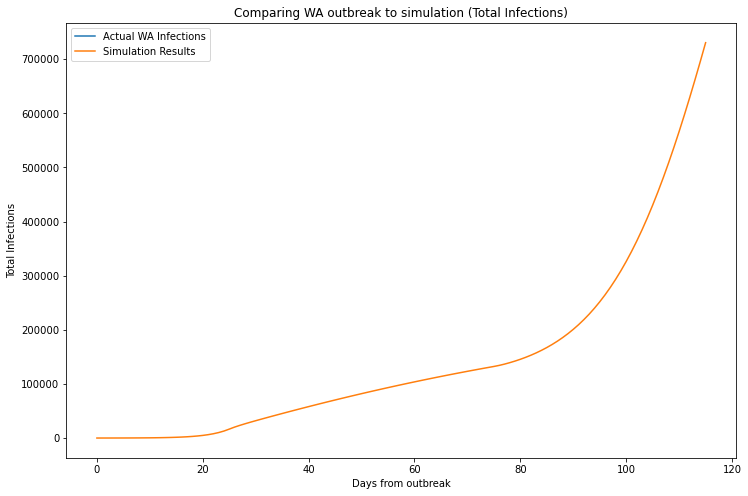

In [345]:
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Total Infections)')
plt.plot(wa_totals, label = 'Actual WA Infections')
plt.plot(day_infs, label = 'Simulation Results')
plt.legend()
plt.ylabel('Total Infections')
plt.xlabel('Days from outbreak')

Text(0.5, 0, 'Days from outbreak')

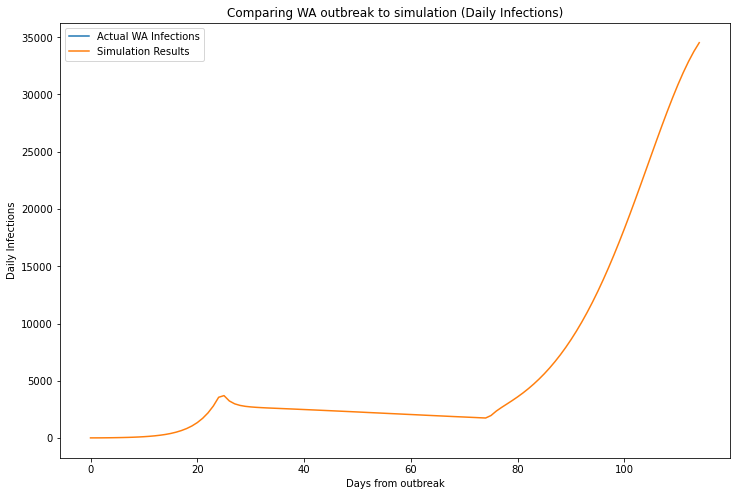

In [346]:
new_infs = [day_infs[i]-day_infs[i-1] for i in range(1,len(day_infs))]
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Daily Infections)')
plt.plot(wa_infs, label = 'Actual WA Infections')
plt.plot(new_infs, label = 'Simulation Results')
plt.legend()
plt.ylabel('Daily Infections')
plt.xlabel('Days from outbreak')

In [347]:
# print when infection breaks in to each town
breaks = dict()
for i in range(num):
    for day in range(days):
        if model[day][i][5] > 0:
            breaks[towns[i]] = breaks.get(towns[i], day)

sd = {k: v for k, v in sorted(breaks.items(), key=lambda item: item[1])}
for item in sd:
    print(item, breaks[item])

print('-----Not Affected-----')
for i in range(num):
    if towns[i] not in breaks.keys():
        print(towns[i])

Perth 0
Mandurah 2
Northam 7
Collie 8
York 9
Karratha 10
Newman 10
Halls Creek 11
Harvey 12
Broome 14
Port Hedland 14
Kalgoorlie-Boulder 15
Carnarvon 15
Capel 15
Paraburdoo 16
Tom Price 17
Donnybrook 17
Bunbury 18
Busselton 18
Manjimup 18
Exmouth 18
Port Denison-Dongara 19
Wickham 19
Dunsborough 20
Geraldton 22
Merredin 22
Cowaramup 22
Kambalda West 23
Jurien Bay 26
Fitzroy Crossing 27
Moora 29
Margaret River 33
Narrogin 46
Kojonup 52
Katanning 57
Wagin 75
Waroona 77
Augusta 103
-----Not Affected-----
Albany
Esperance
Kununurra
Derby
Denmark
Mount Barker
Little Grove
Kalbarri
Boddington-Ranford
Wyndham


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


1874579.0
71090.0
31983.0
29876.0
29372.0
25330.0
15829.0
13984.0
13829.0
10420.0
7192.0
6548.0
6392.0
6039.0
4566.0
4427.0
4342.0
4273.0
4212.0
3702.0
3324.0
2956.0
2783.0
2750.0
2637.0
2557.0
2548.0
2519.0
2486.0
2397.0
2019.0
1905.0
1790.0
1703.0
1577.0
1571.0
1546.0
1546.0
1424.0
1358.0
1357.0
1349.0
1164.0
1147.0
1142.0
1109.0
80812.0
781.0


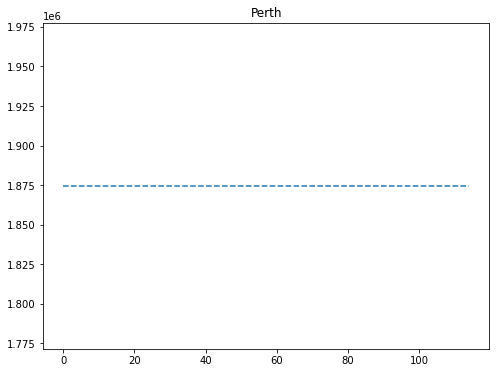

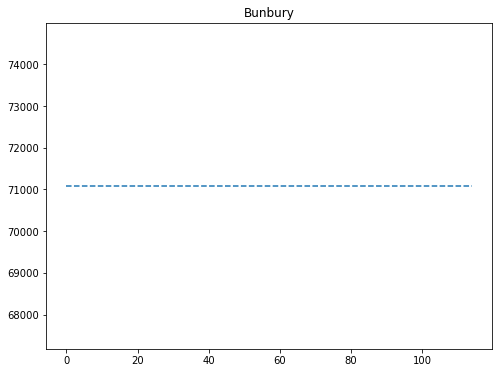

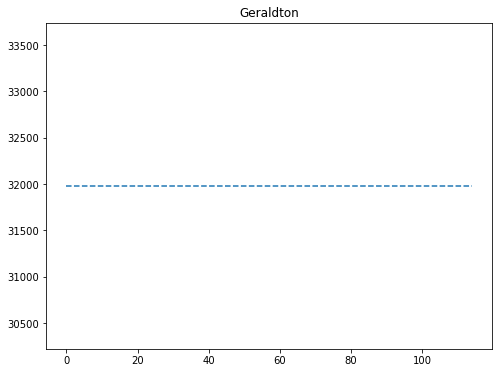

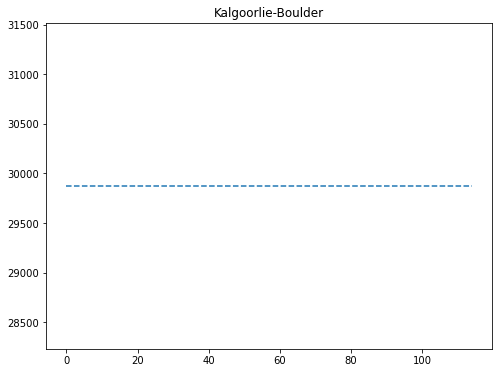

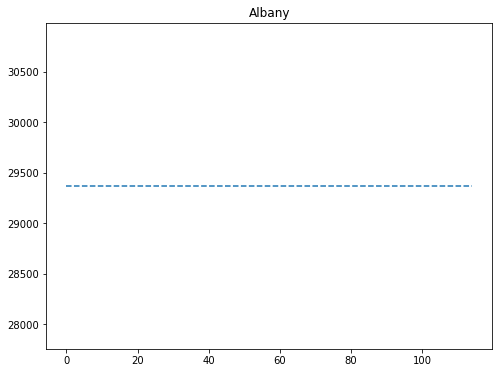

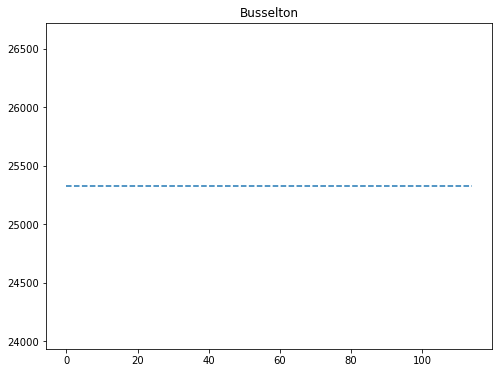

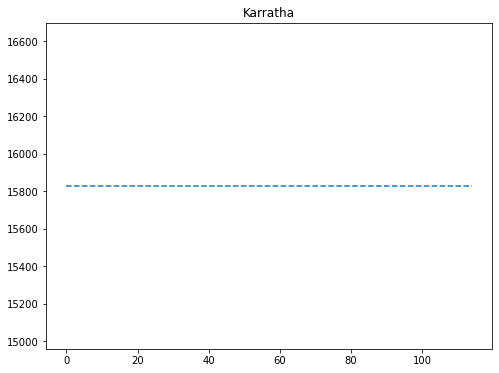

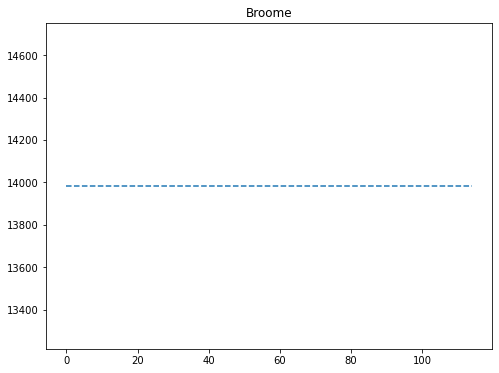

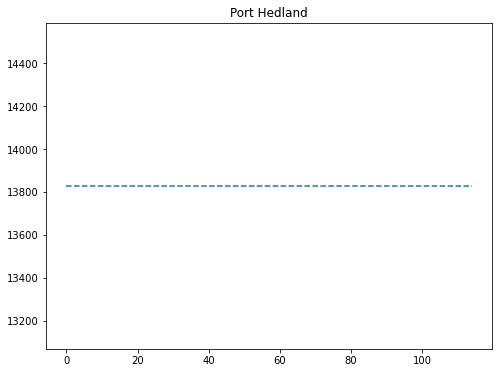

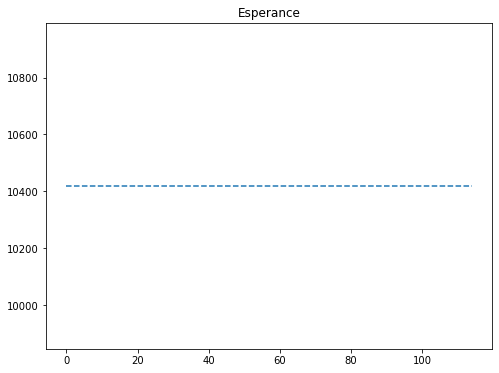

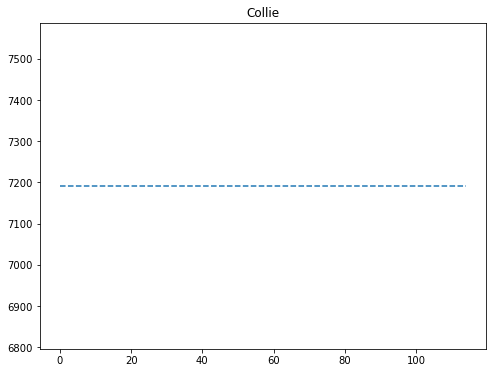

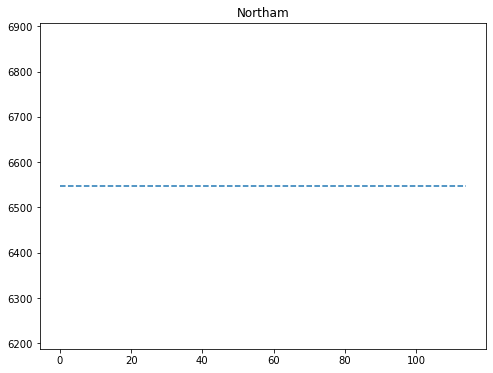

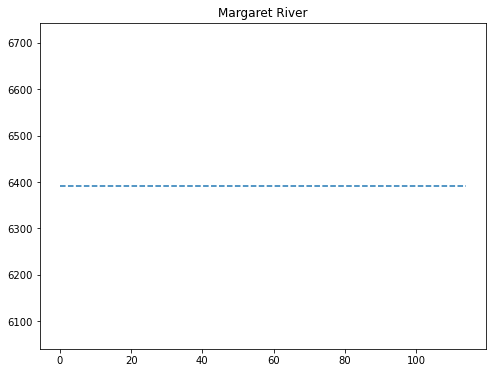

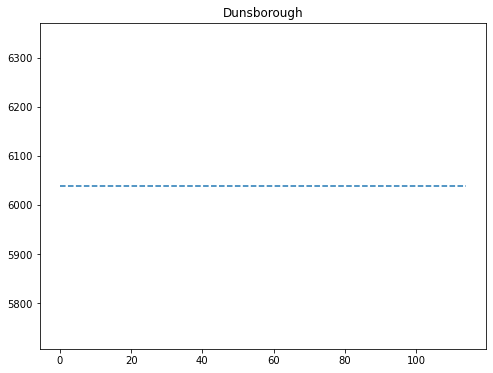

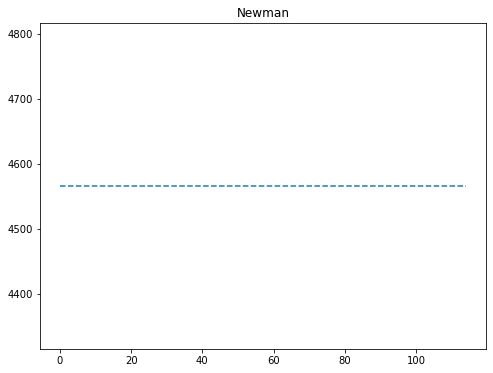

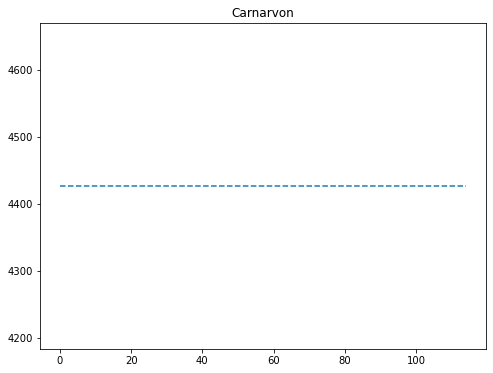

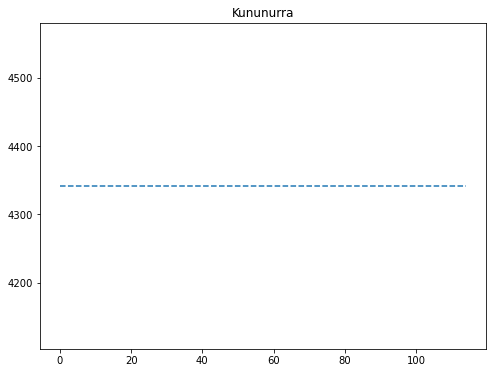

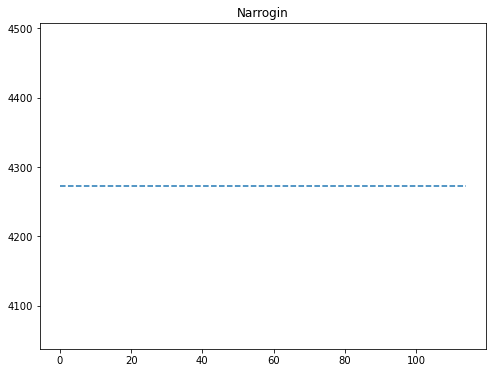

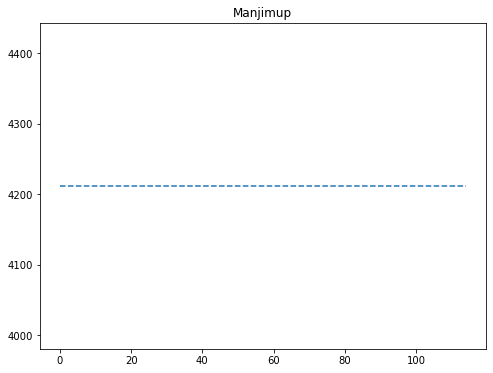

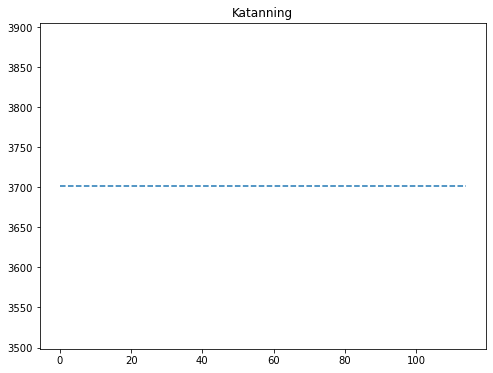

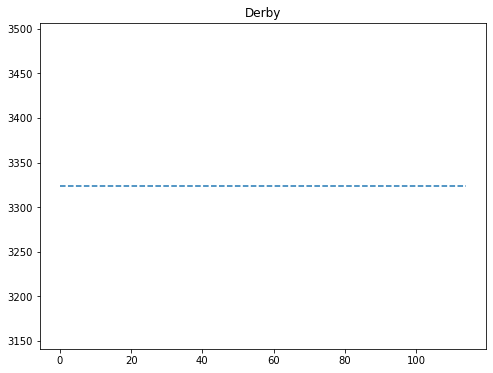

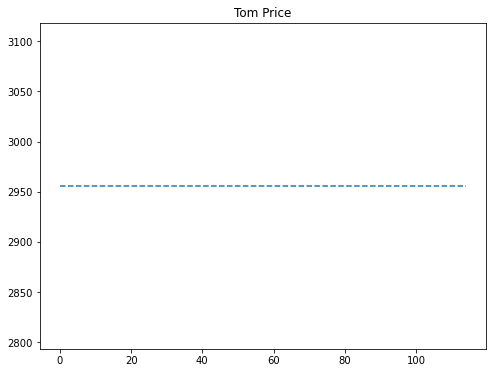

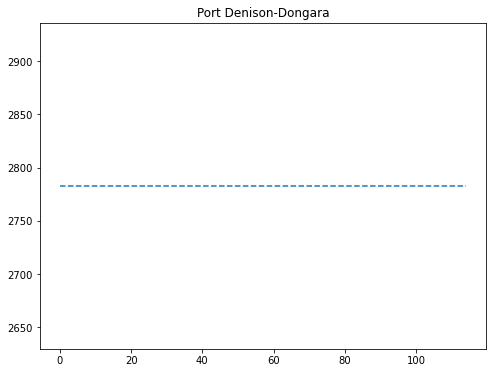

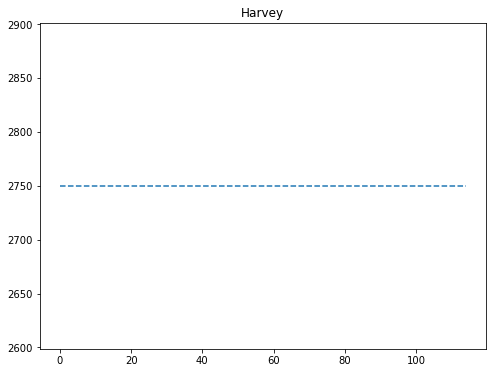

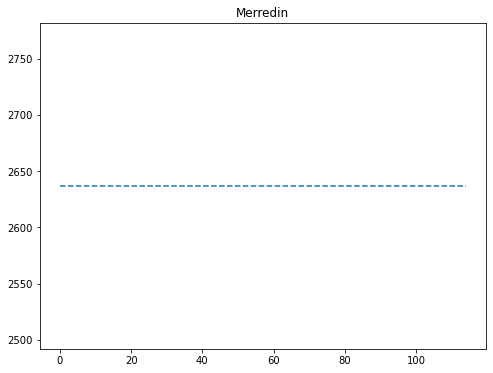

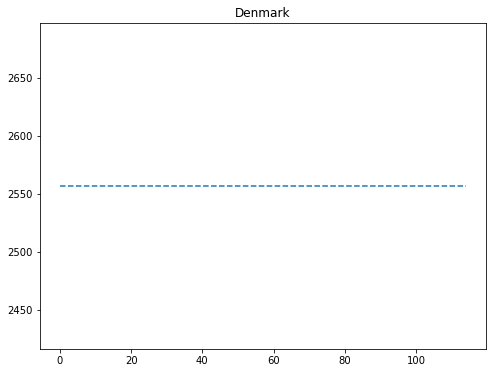

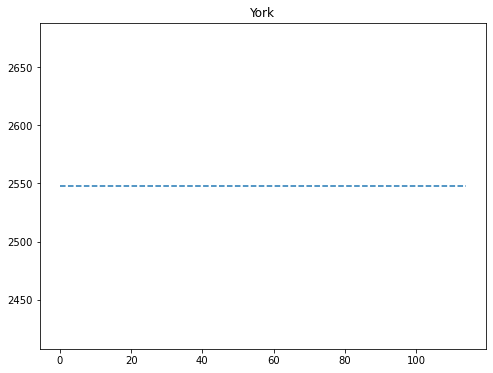

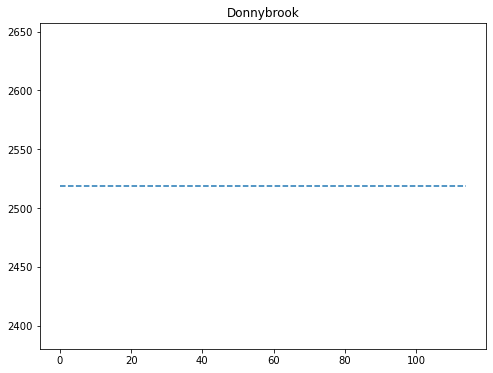

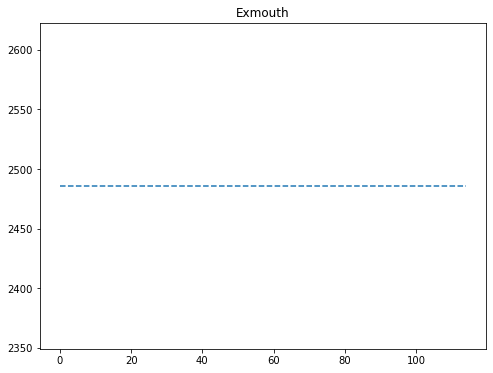

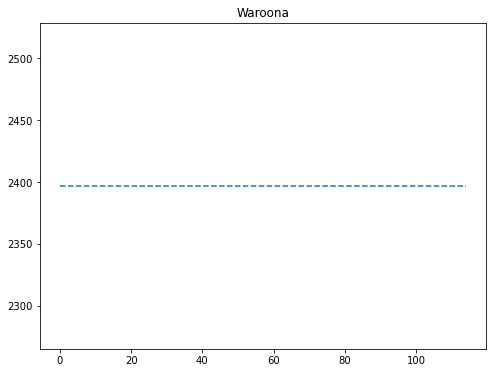

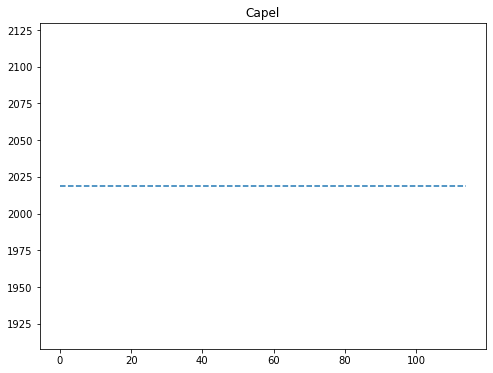

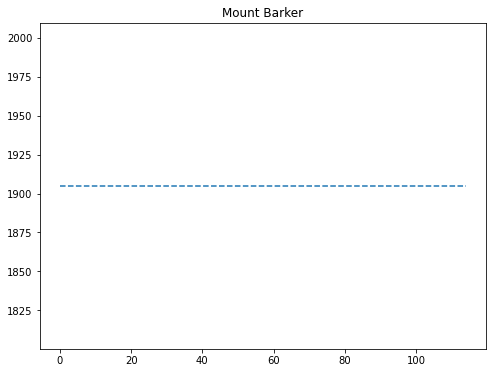

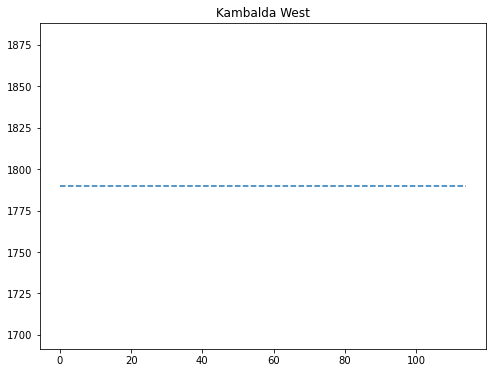

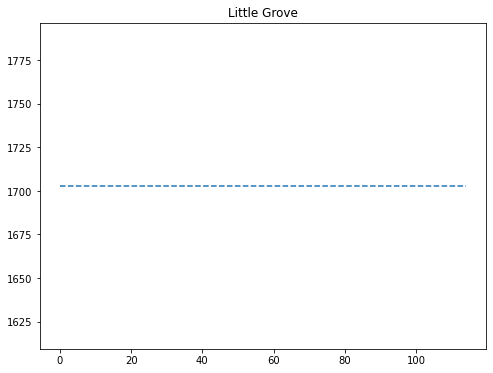

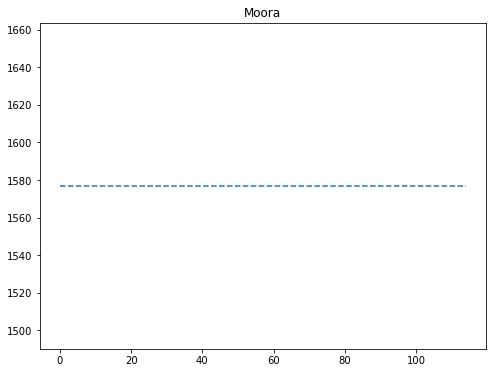

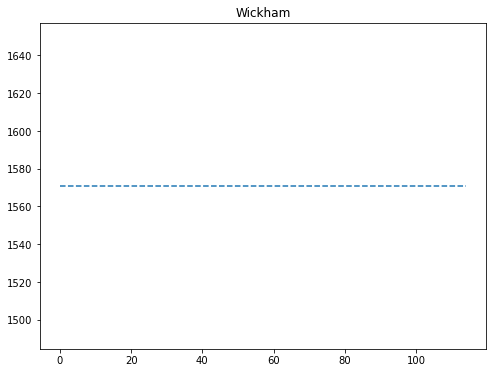

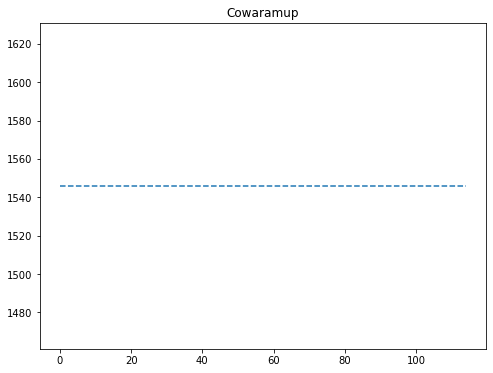

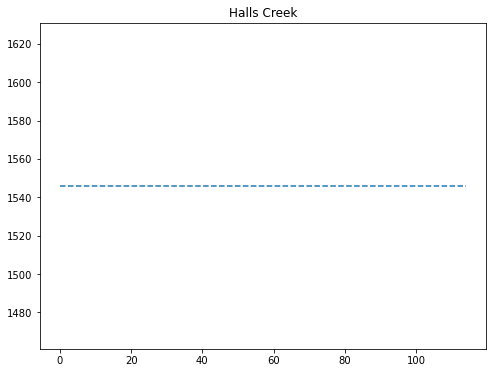

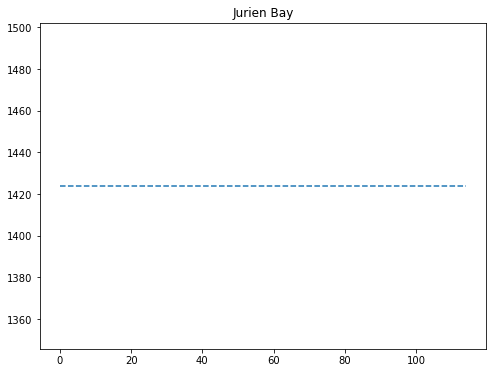

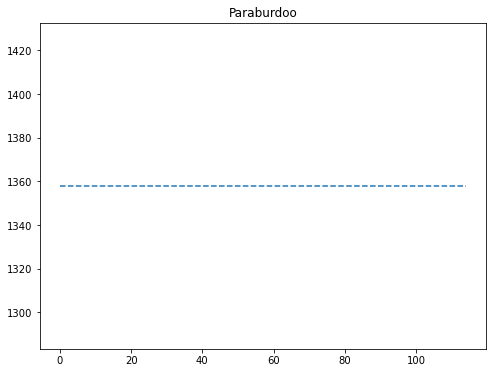

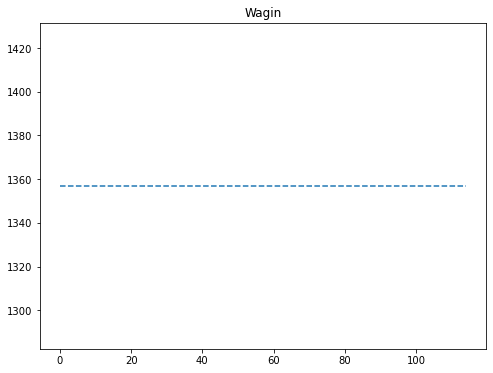

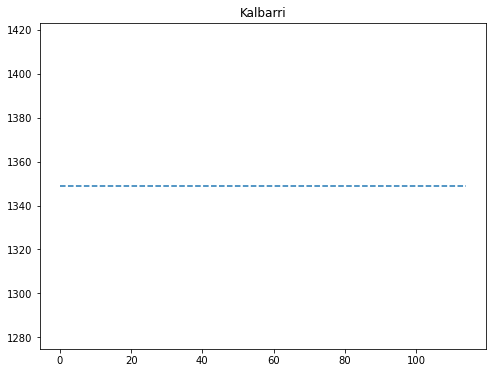

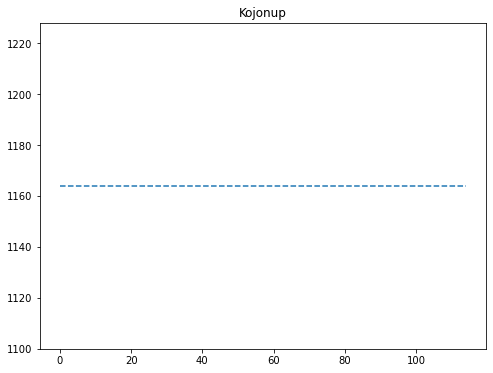

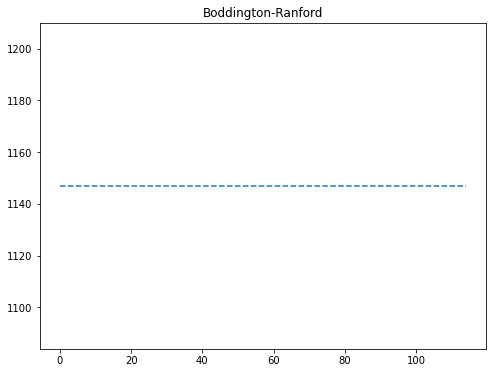

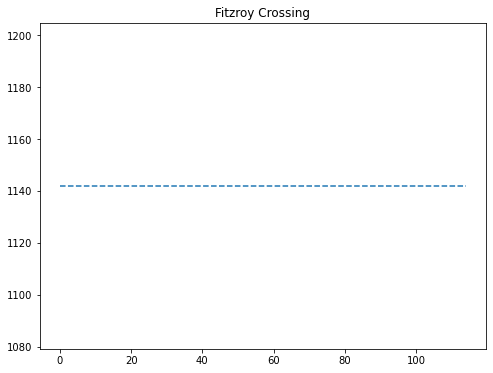

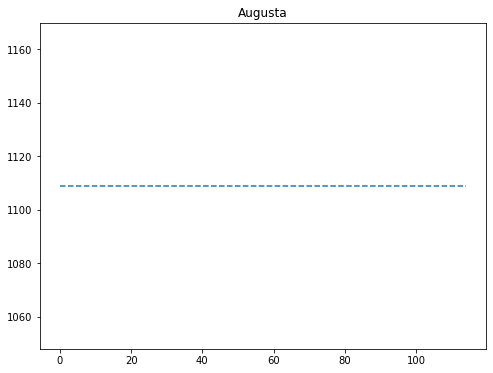

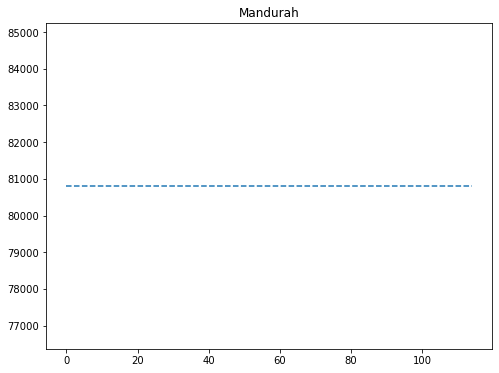

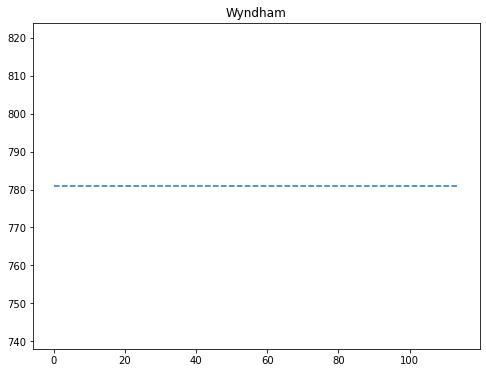

In [354]:
# compartments = ['Sus', 'V1', 'V2', 'V3', 'Exp', 'Inf', 'Rec']
tot = []
for town in range(num):
    plt.figure(figsize = (8,6))
    plt.title(towns[town])
    total_pop = []
    for k in range(8):
        if k < 7:
            continue
        #if k == 5:
#             llist = []
#             for day in range(len(model)):
#                 llist.append(model[day][town][k])
#             plt.plot(llist,label = compartments[k])
        else:
            for day in range(days):
                total_pop.append(sum(model[day][town]))
    tot.append(total_pop)
    plt.plot(total_pop, linestyle = 'dashed', label = 'Pop')
for t in tot:
    print(np.mean(t))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


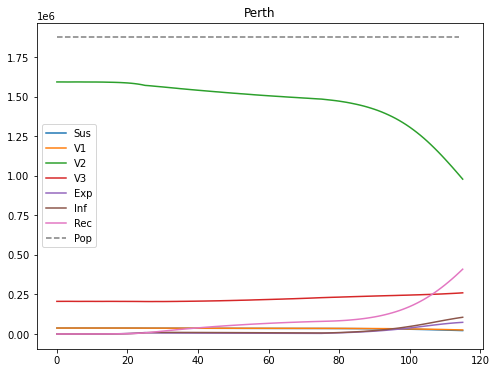

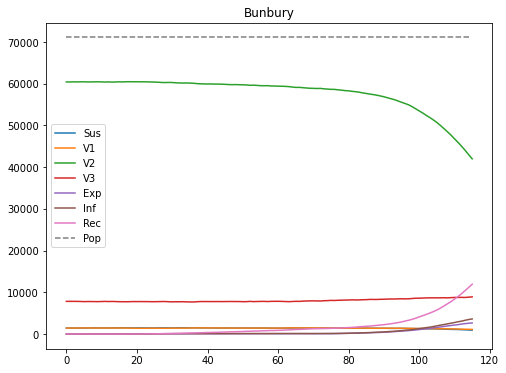

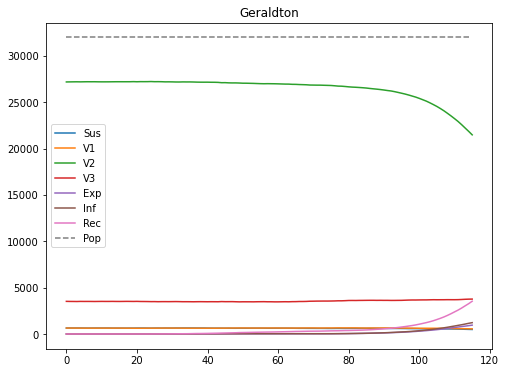

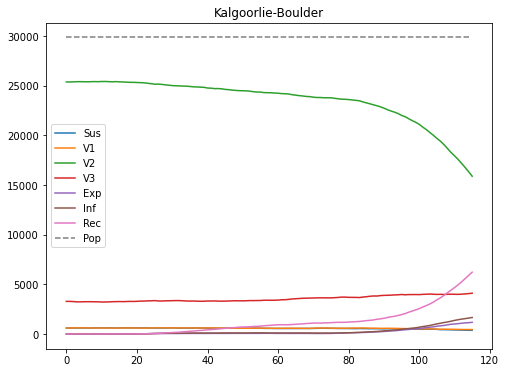

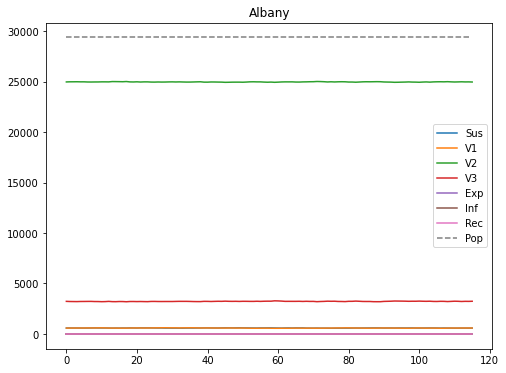

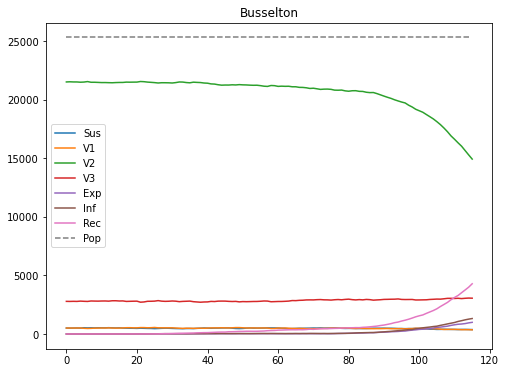

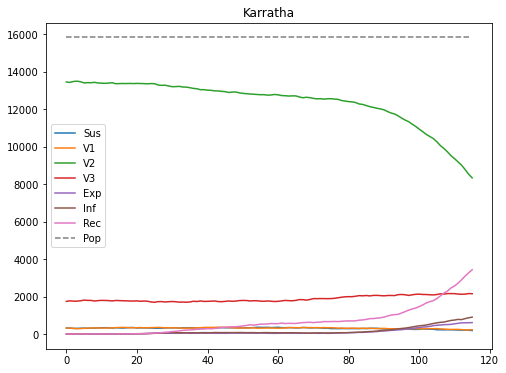

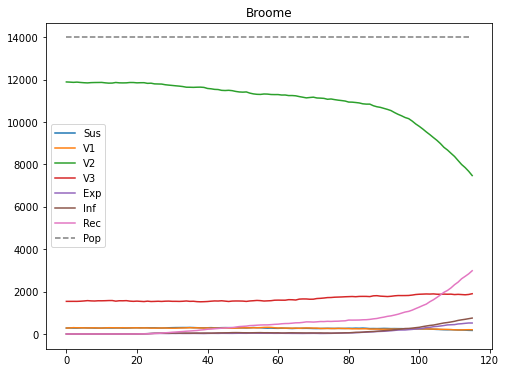

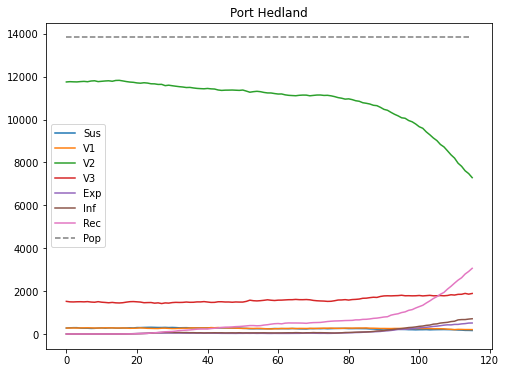

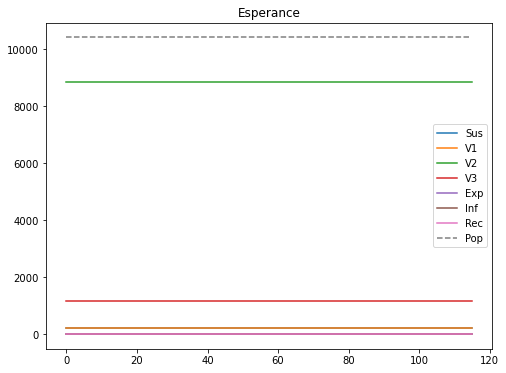

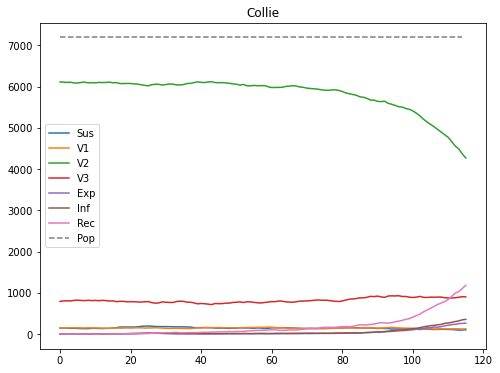

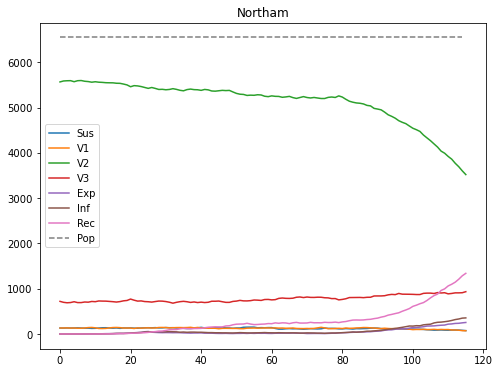

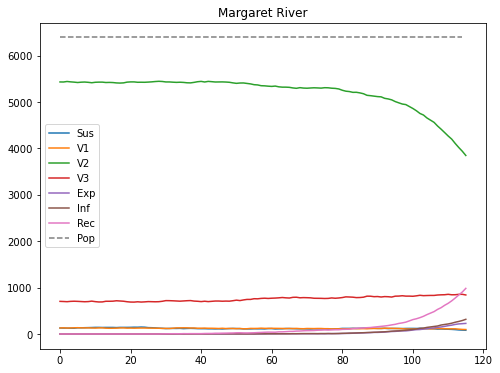

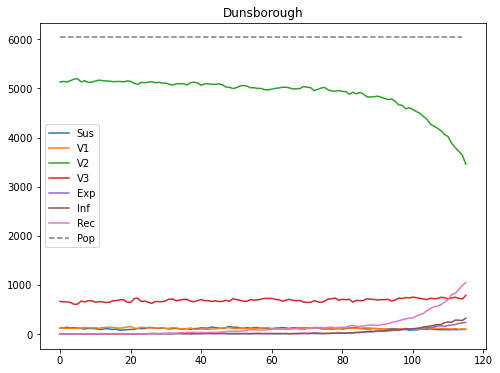

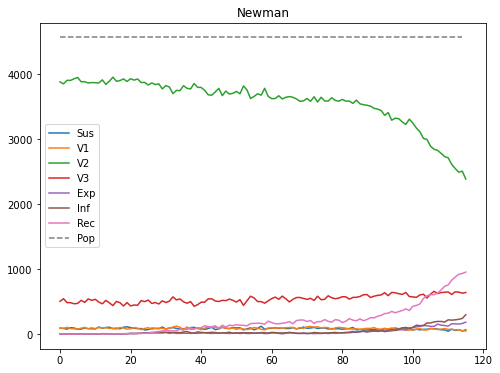

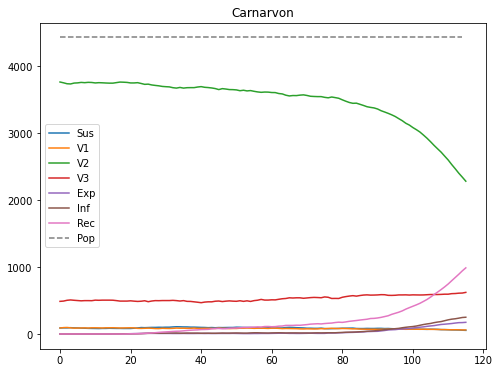

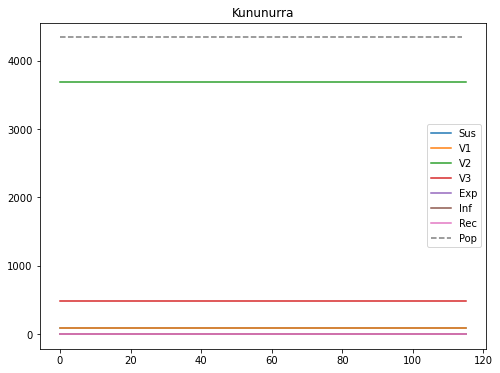

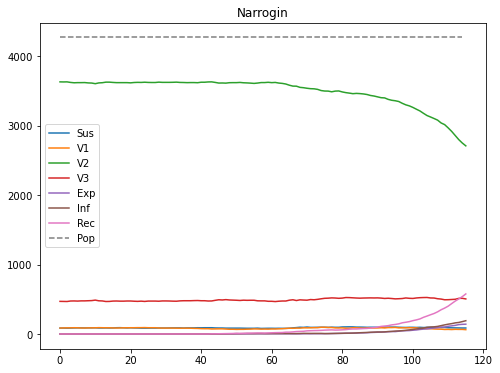

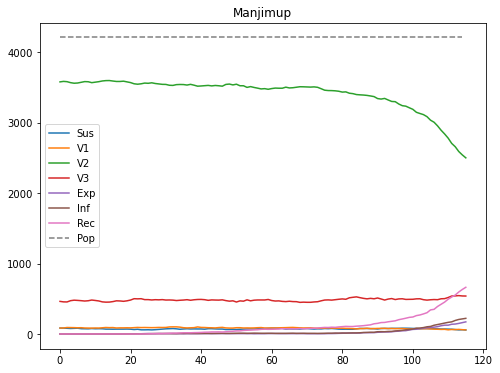

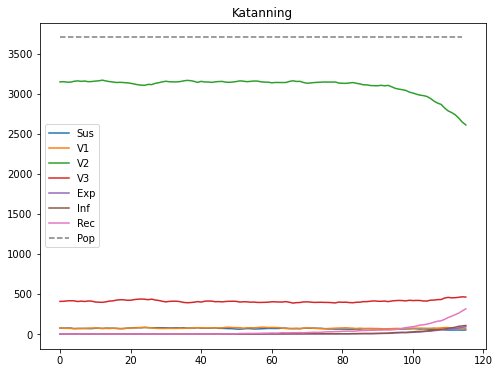

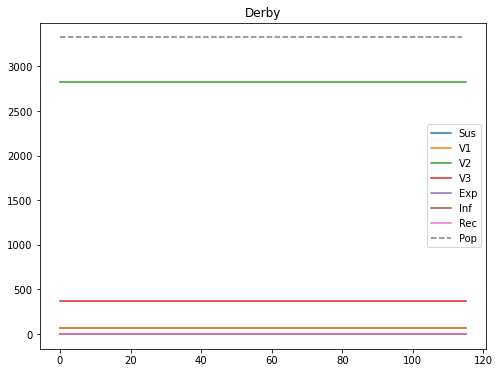

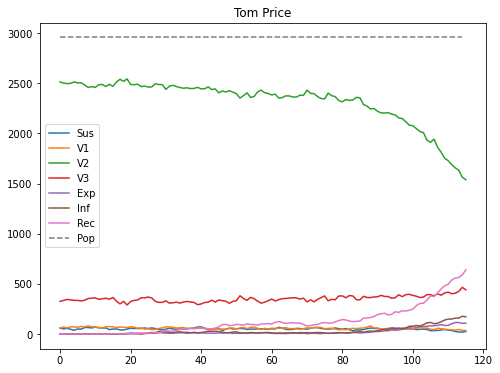

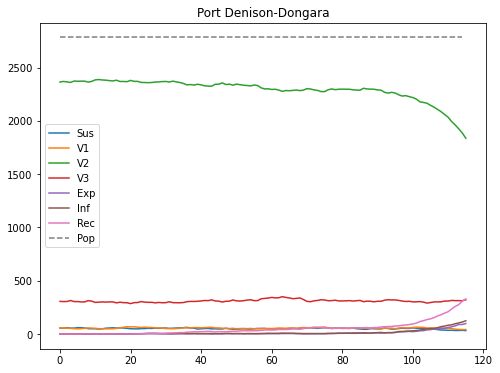

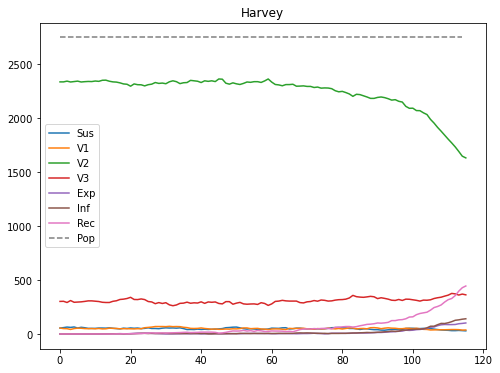

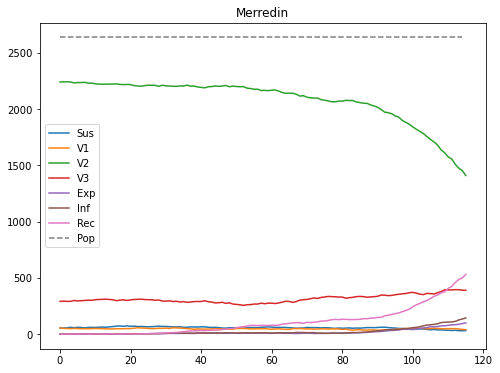

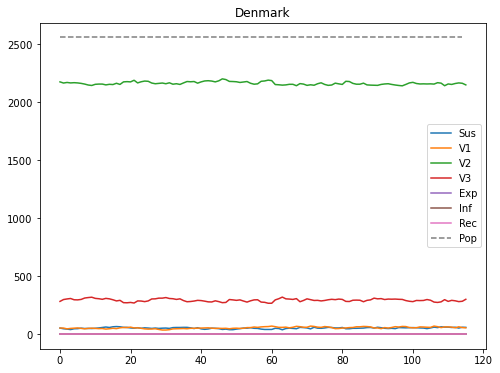

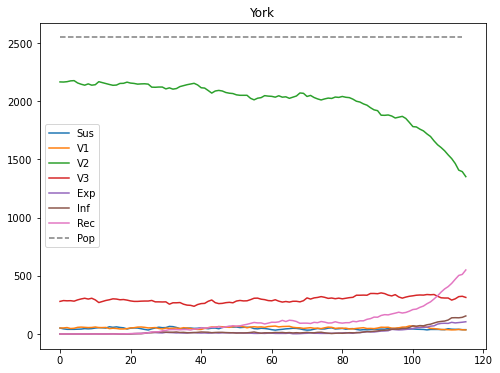

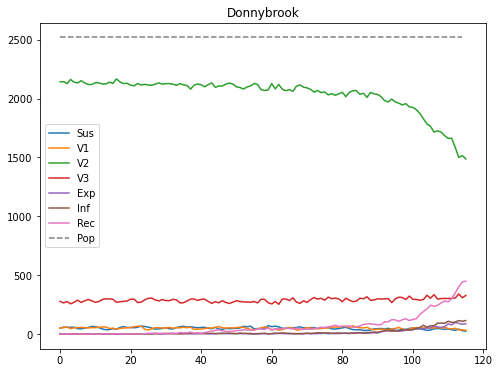

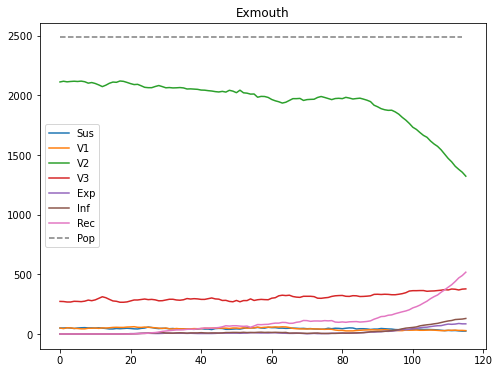

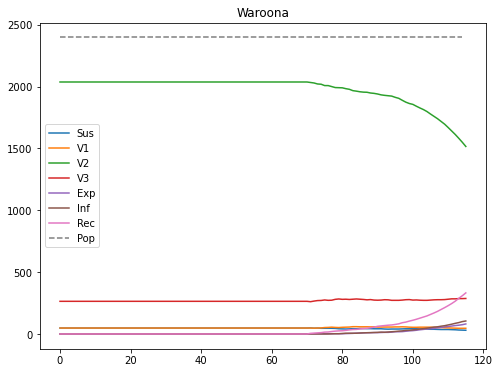

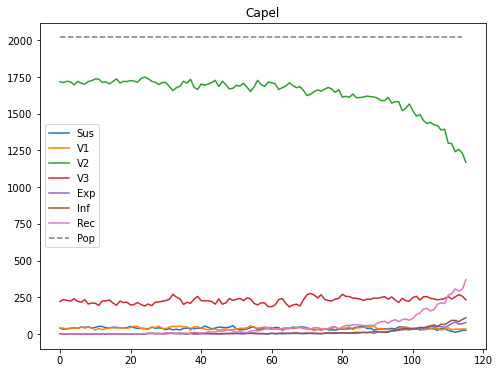

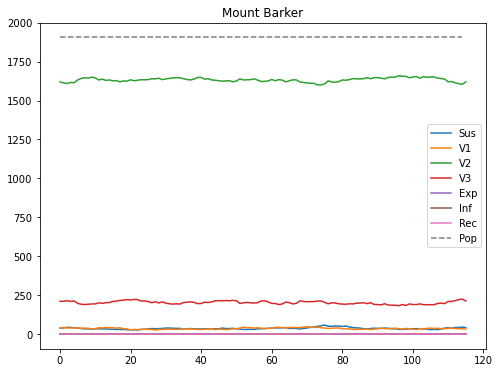

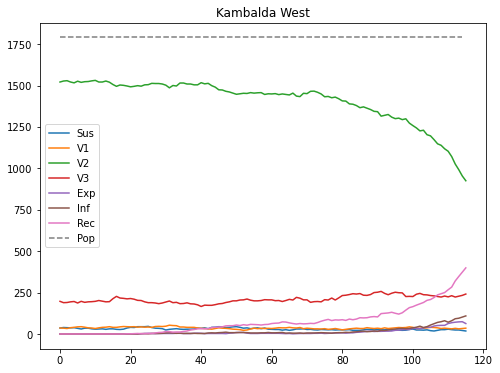

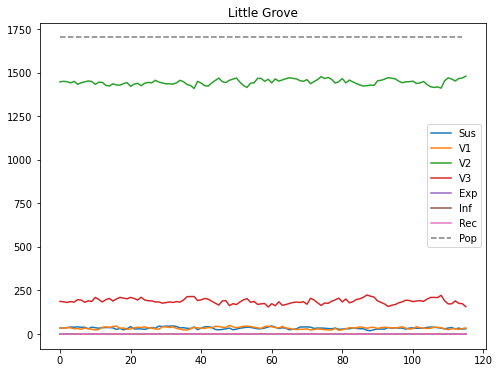

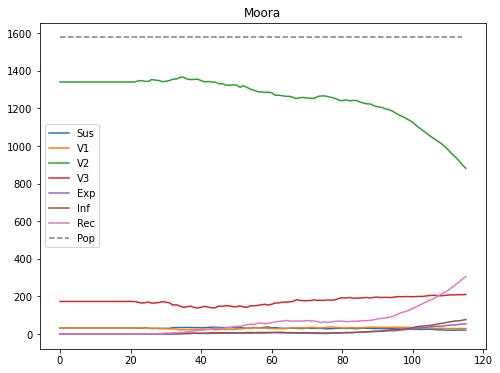

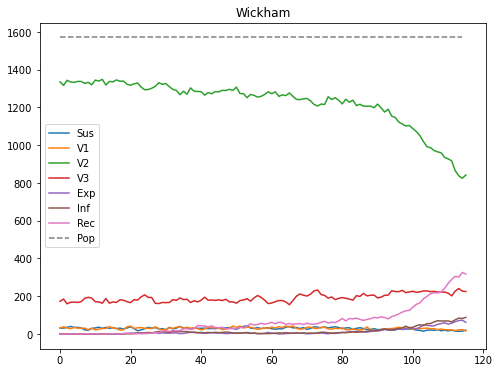

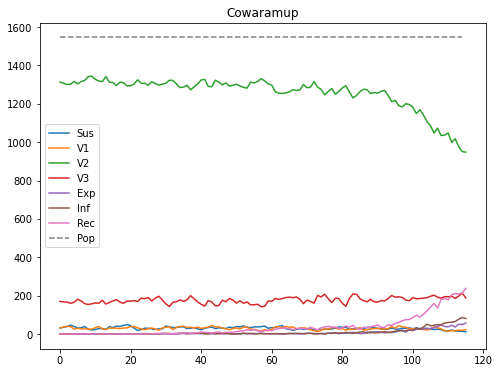

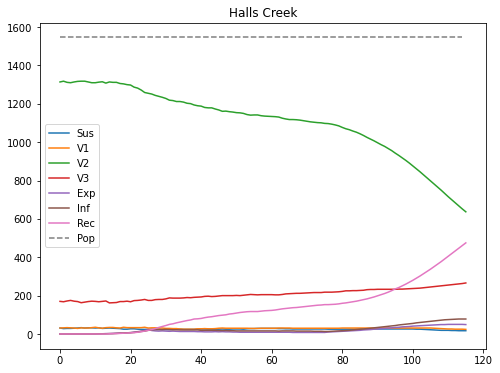

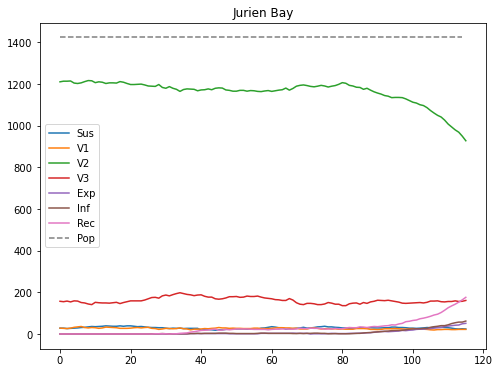

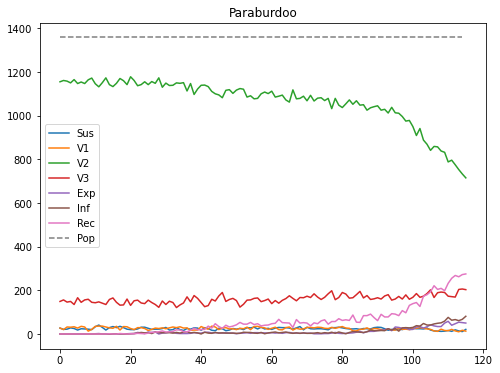

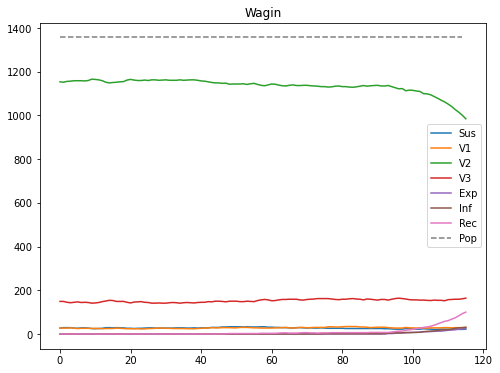

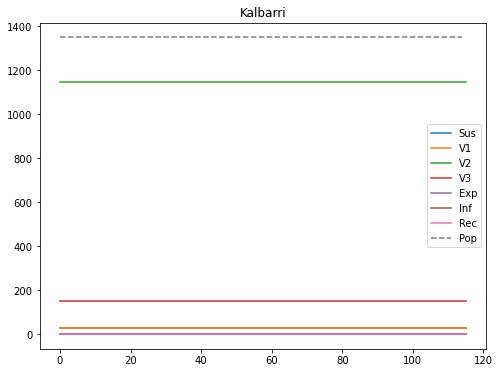

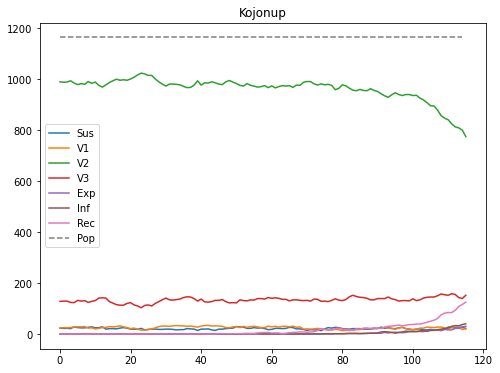

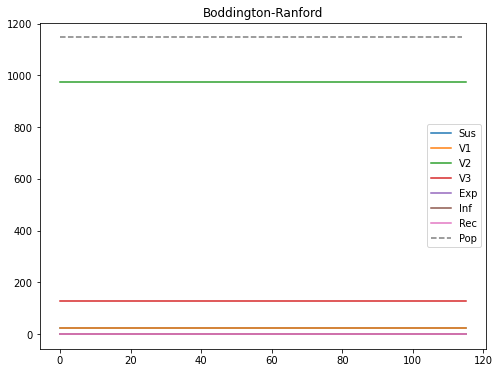

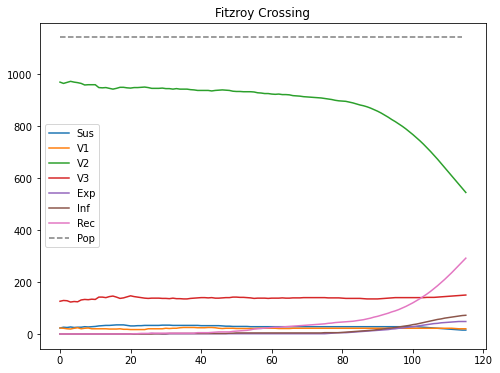

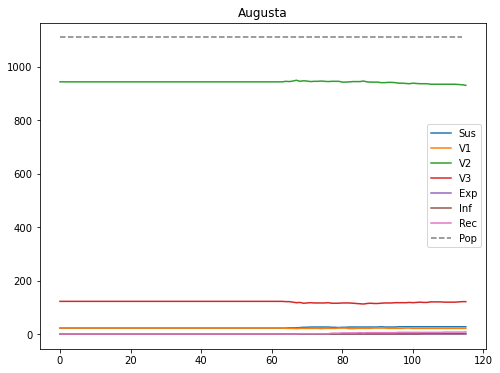

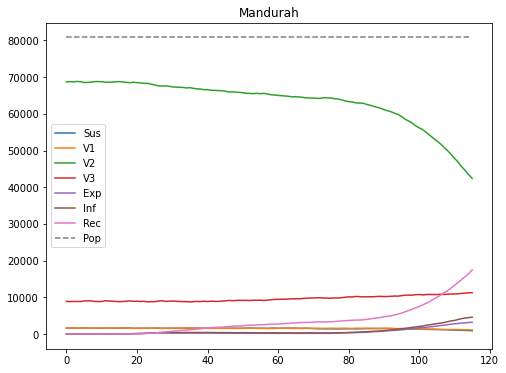

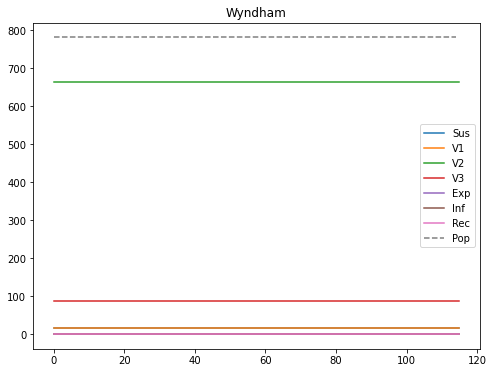

In [349]:
compartments = ['Sus', 'V1', 'V2', 'V3', 'Exp', 'Inf', 'Rec']
for town in range(num):
    plt.figure(figsize = (8,6))
    plt.title(towns[town])
    total_pop = []
    for k in range(8):
        if k < 7:
        #if k == 5:
            llist = []
            for day in range(len(model)):
                llist.append(model[day][town][k])
            plt.plot(llist,label = compartments[k])
        else:
            for day in range(days):
                total_pop.append(sum(model[day][town]))
    plt.plot(total_pop, linestyle = 'dashed', label = 'Pop')
    plt.legend()

In [350]:
len(model[0])

48

In [351]:
waloc

,City / Town,Population,long,latt
0,Perth,1874578,115.860500,-31.9505
1,Bunbury,71090,115.639600,-33.3256
2,Geraldton,31982,114.614400,-28.7797
3,Kalgoorlie-Boulder,29875,121.466000,-30.7490
4,Albany,29373,117.883700,-35.0269
5,Busselton,25329,115.345500,-33.6532
6,Karratha,15828,116.845800,-20.7353
7,Broome,13984,122.230400,-17.9644
8,Port Hedland,13828,118.486400,-20.9818
9,Esperance,10421,121.992800,-33.4866


In [352]:
#Check for negatives
for i in range(len(model)):
    for j in range(len(model[0])):
        for k in range(len(model[0][0])):
            if model[i][j][k] <0 :
                print(i,j,k,model[i][j][k])

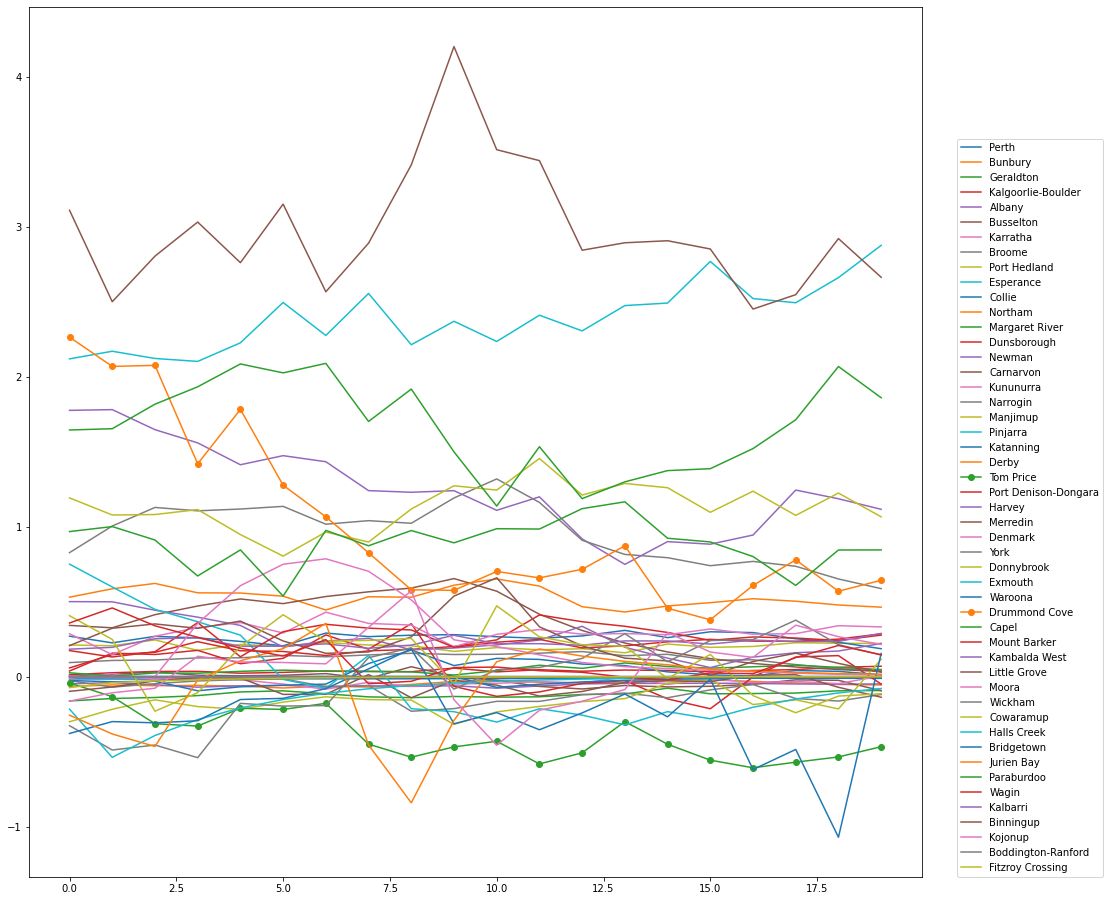

In [82]:
plt.figure(figsize = (16,16))
for i in range(num):
    di = []
    for j in range(20):
        df = d[str(70+j)].copy()*C
    #print(sum(df[50]))
    #print(sum(df.iloc[50]))
        di.append((sum(df[i]) - sum(df.iloc[i]))/popn[i])
    if i == 50 or i==31 or i == 22:
        plt.plot(di, label = towns[i], marker = 'o')
    else:
        plt.plot(di, label = towns[i])
plt.legend(loc=(1.04,0))
    #diff.append(di)
        #print('Diff = ', (sum(df[50]) - sum(df.iloc[50]))/popn[50], i)